## Using XGBOOST as a classifier to predict whether the close price of QQQ in the next day is going to be greater than the previous day's closing price

In the first portion of this notebook a classification model is trained on OHLC daily data between 2010 and 2022 to predict the stock prices of QQQ exchange-traded fund. Here are the steps involved in the code:

- The code imports several libraries required for data gathering, preprocessing, feature engineering, model training, and evaluation.

- The code downloads the historical stock prices of QQQ exchange-traded fund from Yahoo Finance using yfinance library and selects the data from 2010 to 2023.

- The code applies several technical indicators to the stock prices using pandas_ta library.

- The code creates six signals based on the technical indicators, such as RSI, SMA, EMA, OBV, CCI, and Stoch.

- The code combines the six signals into a single "signal" column.

- The code creates a binary target variable "Next_Day_Price" based on the direction of the price change between the current and the next day's closing prices.
- The code drops the unnecessary columns and scales the remaining features using StandardScaler.
- The code uses SMOTETomek algorithm to oversample the minority class and balance the class distribution.
- The code defines a search space for hyperparameters of XGBoost classifier using Bayesian optimization and time-series cross-validation.
- The code fits the XGBoost classifier to the resampled and scaled data using the best hyperparameters found by the Bayesian optimization.
- The code prints the best hyperparameters and precision score of the trained model.
- The overall goal of the code is to predict the direction of the QQQ ETF price changes based on the technical indicators using a machine learning model.

In [1]:
import yfinance as yf
import pandas_ta as ta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from multiprocessing import cpu_count
# Step 1: Gather and clean the data
df = yf.download("QQQ", start="2010-01-01", end="2023-01-01")
df = df.dropna()

# Add technical indicators
df.ta.rsi(append=True)
df.ta.sma(length=10, append=True)
df.ta.sma(length=20, append=True)
df.ta.ema(length=10, append=True)
df.ta.ema(length=20, append=True)
df.ta.cci(append=True)
df.ta.adx(append=True)
df.ta.kama(append=True)
df.ta.bbands(length=20, append=True)
df.ta.obv(append=True)
df.ta.bbands(length=20, append=True)
df.ta.cci(length=20, c=0.015, append=True)
df.ta.stoch(append=True)
df.ta.macd(append = True)
# Create signals
df['rsi_signal'] = 0
df.loc[df['RSI_14'] < 30, 'rsi_signal'] = 1
df.loc[df['RSI_14'] > 70, 'rsi_signal'] = -1

df['sma_signal'] = 0
df.loc[df['SMA_10'] > df['SMA_20'], 'sma_signal'] = 1
df.loc[df['SMA_10'] < df['SMA_20'], 'sma_signal'] = -1

df['ema_signal'] = 0
df.loc[df['EMA_10'] > df['EMA_20'], 'ema_signal'] = 1
df.loc[df['EMA_10'] < df['EMA_20'], 'ema_signal'] = -1

df['macd_signal'] = 0
df.loc[df['MACDh_12_26_9'] > 0, 'macd_signal'] = 1
df.loc[df['MACD_12_26_9'] < 0, 'macd_signal'] = -1

df['obv_signal'] = 0
df.loc[df['OBV'] > df['OBV'].shift(), 'obv_signal'] = 1
df.loc[df['OBV'] < df['OBV'].shift(), 'obv_signal'] = -1

df['cci_signal'] = 0
df.loc[(df['CCI_20_0.015'] < -100), 'cci_signal'] = 1
df.loc[(df['CCI_20_0.015'] > 100), 'cci_signal'] = -1


df['stoch_signal'] = 0
df.loc[(df['STOCHk_14_3_3'] < 20), 'stoch_signal'] = 1
df.loc[(df['STOCHk_14_3_3'] > 80), 'stoch_signal'] = -1



df['signal'] = df['rsi_signal'] + df['sma_signal'] + df['ema_signal'] + df['cci_signal'] + df['macd_signal'] + df['obv_signal']

#########
df["Close_Shifted"] = df["Close"].shift(-1)
df["Next_Day_Price"] = (df["Close"] < df["Close_Shifted"]).astype(int)
df = df.drop(columns=["Close_Shifted"])
df = df.dropna()
# Step 2: Prepare the data for modeling
X = df.iloc[:, :-1]
y = df["Next_Day_Price"]


# Step 3: Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 4: Fix class imbalance
smt = SMOTETomek(random_state=42)
X_resampled, y_resampled = smt.fit_resample(X, y)

# Step 5: Define the search space for hyperparameters
param_space = {
    "n_estimators": Integer(50, 200),
    "max_depth": Integer(10, 100),
    "learning_rate": Real(0.01, 1),
    "gamma": Real(0, 1),
    "reg_alpha": Real(0, 1),
    "reg_lambda": Real(0, 1)
}


# Step 6: Perform Bayesian optimization with time series cross-validation
xgb = XGBClassifier(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)
bayes_search = BayesSearchCV(
    xgb, 
    param_space, 
    cv=tscv,
    scoring='recall',
    n_iter=40,
    verbose=0,
    n_jobs=cpu_count()
)

# Step 7: Fit the model to the data
bayes_search.fit(X_resampled, y_resampled)

# Step 8: Print the best hyperparameters and precision score
print("Best hyperparameters:", bayes_search.best_params_)
print("Precision score:", bayes_search.best_score_)

# Step 9: Deploy the model with the best hyperparameters
best_xgb = bayes_search.best_estimator_
best_xgb.fit(X_resampled, y_resampled)

# Step 10: Make predictions and evaluate the model
y_pred = best_xgb.predict(X)
accuracy = accuracy_score(y, y_pred)
classification_report = classification_report(y, y_pred, digits=4)
precision = precision_score(y, y_pred)
confusion_matrix = confusion_matrix(y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Classification Report:\n", classification_report)
print("Confusion Matrix:\n", confusion_matrix)

[*********************100%***********************]  1 of 1 completed
Best hyperparameters: OrderedDict([('gamma', 0.36236547168990246), ('learning_rate', 0.5864391081907592), ('max_depth', 82), ('n_estimators', 69), ('reg_alpha', 0.8797226040199367), ('reg_lambda', 0.6861931934880896)])
Precision score: 0.5755357370452381
Accuracy: 0.8937943809817845
Precision: 0.8954570333880679
Classification Report:
               precision    recall  f1-score   support

           0     0.8916    0.8683    0.8798      1450
           1     0.8955    0.9145    0.9049      1789

    accuracy                         0.8938      3239
   macro avg     0.8936    0.8914    0.8923      3239
weighted avg     0.8937    0.8938    0.8936      3239

Confusion Matrix:
 [[1259  191]
 [ 153 1636]]


## Testing the model on data from 2023.

In [2]:
# Step 1: Gather and clean the data
df = yf.download("QQQ", start="2023-01-02", end="2023-04-08")
df = df.dropna()

# Add technical indicators
df.ta.rsi(append=True)
df.ta.sma(length=10, append=True)
df.ta.sma(length=20, append=True)
df.ta.ema(length=10, append=True)
df.ta.ema(length=20, append=True)
df.ta.cci(append=True)
df.ta.adx(append=True)
df.ta.kama(append=True)
df.ta.bbands(length=20, append=True)
df.ta.obv(append=True)
df.ta.bbands(length=20, append=True)
df.ta.cci(length=20, c=0.015, append=True)
df.ta.stoch(append=True)
df.ta.macd(append = True)
# Create signals
df['rsi_signal'] = 0
df.loc[df['RSI_14'] < 30, 'rsi_signal'] = 1
df.loc[df['RSI_14'] > 70, 'rsi_signal'] = -1

df['sma_signal'] = 0
df.loc[df['SMA_10'] > df['SMA_20'], 'sma_signal'] = 1
df.loc[df['SMA_10'] < df['SMA_20'], 'sma_signal'] = -1

df['ema_signal'] = 0
df.loc[df['EMA_10'] > df['EMA_20'], 'ema_signal'] = 1
df.loc[df['EMA_10'] < df['EMA_20'], 'ema_signal'] = -1

df['macd_signal'] = 0
df.loc[df['MACDh_12_26_9'] > 0, 'macd_signal'] = 1
df.loc[df['MACD_12_26_9'] < 0, 'macd_signal'] = -1

df['obv_signal'] = 0
df.loc[df['OBV'] > df['OBV'].shift(), 'obv_signal'] = 1
df.loc[df['OBV'] < df['OBV'].shift(), 'obv_signal'] = -1

df['cci_signal'] = 0
df.loc[(df['CCI_20_0.015'] < -100), 'cci_signal'] = 1
df.loc[(df['CCI_20_0.015'] > 100), 'cci_signal'] = -1


df['stoch_signal'] = 0
df.loc[(df['STOCHk_14_3_3'] < 20), 'stoch_signal'] = 1
df.loc[(df['STOCHk_14_3_3'] > 80), 'stoch_signal'] = -1



df['signal'] = df['rsi_signal'] + df['sma_signal'] + df['ema_signal'] + df['cci_signal'] + df['macd_signal'] + df['obv_signal']

#########
df["Close_Shifted"] = df["Close"].shift(-1)
df["Next_Day_Price"] = (df["Close"] < df["Close_Shifted"]).astype(int)
df = df.drop(columns=["Close_Shifted"])
df = df.dropna()
# Step 2: Prepare the data for modeling
X = df.iloc[:, :-1]
y = df["Next_Day_Price"]
print(X.columns)
#print(y.columns)
# Step 3: Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

[*********************100%***********************]  1 of 1 completed
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI_14',
       'SMA_10', 'SMA_20', 'EMA_10', 'EMA_20', 'CCI_14_0.015', 'ADX_14',
       'DMP_14', 'DMN_14', 'KAMA_10_2_30', 'BBL_20_2.0', 'BBM_20_2.0',
       'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0', 'OBV', 'CCI_20_0.015',
       'STOCHk_14_3_3', 'STOCHd_14_3_3', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9', 'rsi_signal', 'sma_signal', 'ema_signal',
       'macd_signal', 'obv_signal', 'cci_signal', 'stoch_signal', 'signal'],
      dtype='object')


In [3]:

import yfinance as yf
import pandas_ta as ta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from multiprocessing import cpu_count
# Step 9: Deploy the model with the best hyperparameters

best_xgb = bayes_search.best_estimator_
best_xgb.fit(X_resampled, y_resampled)

# Step 10: Make predictions and evaluate the model
y_pred = best_xgb.predict(X)
accuracy = accuracy_score(y, y_pred)
classification_report = classification_report(y, y_pred, digits=4)
precision = precision_score(y, y_pred)
confusion_matrix = confusion_matrix(y, y_pred)
df['y_pred'] = y_pred

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Classification Report:\n", classification_report)
print("Confusion Matrix:\n", confusion_matrix)

Accuracy: 0.6666666666666666
Precision: 0.7222222222222222
Classification Report:
               precision    recall  f1-score   support

           0     0.6000    0.6429    0.6207        14
           1     0.7222    0.6842    0.7027        19

    accuracy                         0.6667        33
   macro avg     0.6611    0.6635    0.6617        33
weighted avg     0.6704    0.6667    0.6679        33

Confusion Matrix:
 [[ 9  5]
 [ 6 13]]


# This model has a presicion of %72 since the begining of this year. Meaning that it correctly predicted that the closing price of the next day would be greater than today's closing price %72 percent of the time. There are multiple ways that may improve the accuracy of this model: 

- First, adding a column that explicilty states whether we are in a bear or bull market. 
- Adding a column that gives a score represinting market sentiment by using a language model. 
- Adding a column that has the Fed interest rates to help the model navigate periods of economical distress. 

## Using XGboost as a regression model to predict the closing price of the next day. 

### This model is more robust than using a neural netwrok sinse it only uses data from the previous day to predict the price of the next day. LSTM or transfromers are much harder train and typically require looking back at data from multiple previous dates.

In [4]:
import yfinance as yf
import pandas_ta as ta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from multiprocessing import cpu_count
# Step 1: Gather and clean the data
df = yf.download("QQQ", start="2010-01-01", end="2023-01-01")
df = df.dropna()

# Add technical indicators
df.ta.rsi(append=True)
df.ta.sma(length=10, append=True)
df.ta.sma(length=20, append=True)
df.ta.ema(length=10, append=True)
df.ta.ema(length=20, append=True)
df.ta.cci(append=True)
df.ta.adx(append=True)
df.ta.kama(append=True)
df.ta.bbands(length=20, append=True)
df.ta.obv(append=True)
df.ta.bbands(length=20, append=True)
df.ta.cci(length=20, c=0.015, append=True)
df.ta.stoch(append=True)
df.ta.macd(append = True)

#########


# Create signals
df['rsi_signal'] = 0
df.loc[df['RSI_14'] < 30, 'rsi_signal'] = 1
df.loc[df['RSI_14'] > 70, 'rsi_signal'] = -1

df['sma_signal'] = 0
df.loc[df['SMA_10'] > df['SMA_20'], 'sma_signal'] = 1
df.loc[df['SMA_10'] < df['SMA_20'], 'sma_signal'] = -1

df['ema_signal'] = 0
df.loc[df['EMA_10'] > df['EMA_20'], 'ema_signal'] = 1
df.loc[df['EMA_10'] < df['EMA_20'], 'ema_signal'] = -1

df['macd_signal'] = 0
df.loc[df['MACDh_12_26_9'] > 0, 'macd_signal'] = 1
df.loc[df['MACD_12_26_9'] < 0, 'macd_signal'] = -1

df['obv_signal'] = 0
df.loc[df['OBV'] > df['OBV'].shift(), 'obv_signal'] = 1
df.loc[df['OBV'] < df['OBV'].shift(), 'obv_signal'] = -1

df['cci_signal'] = 0
df.loc[(df['CCI_20_0.015'] < -100), 'cci_signal'] = 1
df.loc[(df['CCI_20_0.015'] > 100), 'cci_signal'] = -1


df['stoch_signal'] = 0
df.loc[(df['STOCHk_14_3_3'] < 20), 'stoch_signal'] = 1
df.loc[(df['STOCHk_14_3_3'] > 80), 'stoch_signal'] = -1



df['signal'] = df['rsi_signal'] + df['sma_signal'] + df['ema_signal'] + df['cci_signal'] + df['macd_signal'] + df['obv_signal']
df["Close_Shifted"] = df["Close"].shift(-1)
#df["Next_Day_Price"] = (df["Close"] < df["Close_Shifted"]).astype(int)
#df = df.drop(columns=["Close_Shifted"])
df = df.dropna()
# Step 2: Prepare the data for modeling
X = df.iloc[:, :-1]
y = df["Close_Shifted"]


# Step 3: Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
y_scaler = StandardScaler()
# Fit and transform the y values
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))

# Step 5: Define the search space for hyperparameters
param_space = {
    "n_estimators": Integer(50, 200),
    "max_depth": Integer(10, 100),
    "learning_rate": Real(0.01, 1),
    "gamma": Real(0, 1),
    "reg_alpha": Real(0, 1),
    "reg_lambda": Real(0, 1)
}


# Step 6: Perform Bayesian optimization with time series cross-validation
xgb = XGBRegressor(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)
bayes_search = BayesSearchCV(
    xgb, 
    param_space, 
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_iter=40,
    verbose=0,
    n_jobs=cpu_count()
)

# Step 7: Fit the model to the data
bayes_search.fit(X, y_scaled)

# Step 8: Print the best hyperparameters and precision score
print("Best hyperparameters:", bayes_search.best_params_)
# Step 9: Deploy the model with the best hyperparameters
best_xgb = bayes_search.best_estimator_
best_xgb.fit(X, y_scaled)

# Step 10: Make predictions and evaluate the model

y_pred = best_xgb.predict(X)
mse = mean_squared_error(y_scaled, y_pred)
r2_score_ = r2_score(y_scaled, y_pred)

print("MSE:", mse)
print("R2 Score:", r2_score_)

[*********************100%***********************]  1 of 1 completed
Best hyperparameters: OrderedDict([('gamma', 0.0), ('learning_rate', 0.8025332227280841), ('max_depth', 45), ('n_estimators', 200), ('reg_alpha', 0.21841745156402081), ('reg_lambda', 0.0)])
MSE: 4.2124239960226153e-05
R2 Score: 0.9999578757600398


In [5]:
# Step 1: Gather and clean the data
df = yf.download("QQQ", start="2023-01-02", end="2023-04-08")
df = df.dropna()
# Add technical indicators
df.ta.rsi(append=True)
df.ta.sma(length=10, append=True)
df.ta.sma(length=20, append=True)
df.ta.ema(length=10, append=True)
df.ta.ema(length=20, append=True)
df.ta.cci(append=True)
df.ta.adx(append=True)
df.ta.kama(append=True)
df.ta.bbands(length=20, append=True)
df.ta.obv(append=True)
df.ta.bbands(length=20, append=True)
df.ta.cci(length=20, c=0.015, append=True)
df.ta.stoch(append=True)
df.ta.macd(append = True)

#########


# Create signals
df['rsi_signal'] = 0
df.loc[df['RSI_14'] < 30, 'rsi_signal'] = 1
df.loc[df['RSI_14'] > 70, 'rsi_signal'] = -1

df['sma_signal'] = 0
df.loc[df['SMA_10'] > df['SMA_20'], 'sma_signal'] = 1
df.loc[df['SMA_10'] < df['SMA_20'], 'sma_signal'] = -1

df['ema_signal'] = 0
df.loc[df['EMA_10'] > df['EMA_20'], 'ema_signal'] = 1
df.loc[df['EMA_10'] < df['EMA_20'], 'ema_signal'] = -1

df['macd_signal'] = 0
df.loc[df['MACDh_12_26_9'] > 0, 'macd_signal'] = 1
df.loc[df['MACD_12_26_9'] < 0, 'macd_signal'] = -1

df['obv_signal'] = 0
df.loc[df['OBV'] > df['OBV'].shift(), 'obv_signal'] = 1
df.loc[df['OBV'] < df['OBV'].shift(), 'obv_signal'] = -1

df['cci_signal'] = 0
df.loc[(df['CCI_20_0.015'] < -100), 'cci_signal'] = 1
df.loc[(df['CCI_20_0.015'] > 100), 'cci_signal'] = -1


df['stoch_signal'] = 0
df.loc[(df['STOCHk_14_3_3'] < 20), 'stoch_signal'] = 1
df.loc[(df['STOCHk_14_3_3'] > 80), 'stoch_signal'] = -1



df['signal'] = df['rsi_signal'] + df['sma_signal'] + df['ema_signal'] + df['cci_signal'] + df['macd_signal'] + df['obv_signal']
df["Close_Shifted"] = df["Close"].shift(-1)
#df["Next_Day_Price"] = (df["Close"] < df["Close_Shifted"]).astype(int)
#df = df.drop(columns=["Close_Shifted"])
df = df.dropna()
# Step 2: Prepare the data for modeling
X = df.iloc[:, :-1]
y = df["Close_Shifted"]


# Step 3: Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 10: Make predictions and evaluate the model

y_pred = best_xgb.predict(X)
mse = mean_squared_error(y_scaler.fit_transform(y.values.reshape(-1, 1)), y_pred)
r2_score_ = r2_score(y_scaler.fit_transform(y.values.reshape(-1, 1)), y_pred)

print("MSE:", mse)
print("R2 Score:", r2_score_)

[*********************100%***********************]  1 of 1 completed
MSE: 0.16984161932394864
R2 Score: 0.8301583806760513


In [6]:
y_pred_unscaled = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
df['Y_predicted'] = y_pred_unscaled

/var/folders/5_/6p2w6v5j56j3cvkx2xzt29xw0000gn/T/ipykernel_18868/3626882307.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Y_predicted'] = y_pred_unscaled


In [7]:
df[["Close","Close_Shifted","Y_predicted"]]

,Close,Close_Shifted,Y_predicted
Date,,,
2023-02-21,294.029999,294.250000,296.762421
2023-02-22,294.250000,296.820007,294.133667
2023-02-23,296.820007,291.850006,297.013733
2023-02-24,291.850006,293.940002,292.727478
2023-02-27,293.940002,293.559998,294.424347
2023-02-28,293.559998,291.200012,294.342529
2023-03-01,291.200012,293.609985,293.217560
2023-03-02,293.609985,299.679993,293.129028
2023-03-03,299.679993,300.019989,300.386414


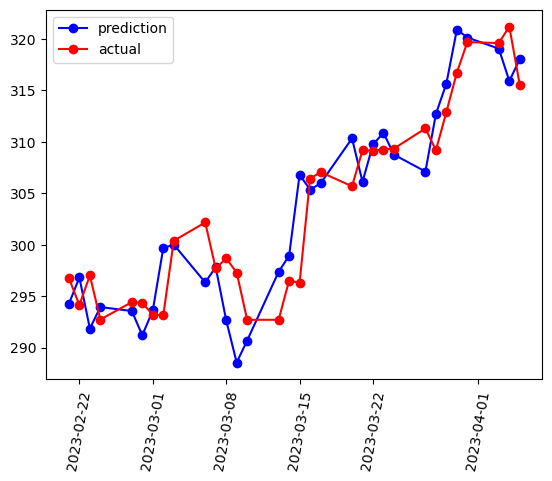

In [8]:
import matplotlib.pyplot as plt
plt.plot(df['Close_Shifted'],'bo-',label= 'prediction');
plt.plot(df['Y_predicted'],'ro-',label= 'actual');
# set the x-axis tick labels at an angle of 80 degrees
plt.xticks(rotation=80);
# set the font size of the x-axis tick labels
plt.xticks(fontsize=10);
plt.legend();